In [1]:
import math
import multiprocessing as mg
import multiprocessing.pool
# import pys2let as ps
import random
import string
import itertools
import os
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav
import matplotlib.pyplot as plt
%matplotlib inline 
import skyclean
from skyclean import CMB_data

In [2]:
def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm


def Single_Map_doubleworker(MW_Pix_Map):
    '''
    Input: MW_Pix_Map: list of mw maps at different scales 
    Each pixel map is a wavelet pixel map of shape (1, Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    It is the output of s2wav.analysis
    (Scale: 0, size (1, 4, 7))

    Process:
    1. Covert MW Pixel Map to MW alm space using s2fft.forward

    2. Add zero to the mw alms  (Is it correct? or should I add zeros to the hp alm's and then convert to mw alm's)
    by adding zeros to the MW alm's we are increasing the resolution of the map
    Double the rows of the mw alms, since, the number of rows represents the L (level of detail)
    
    3. Convert mw alm to mw map 
    
    '''
    # print("original Pixel Map size", MW_Pix_Map.shape)
    MW_alm = s2fft.forward(MW_Pix_Map, L = MW_Pix_Map.shape[1])
    # print("original alm size", MW_alm)
    # 4,7 --> 
    # 2*8-1
    # print(MW_alm)
    # print("Scale:",i,"original alm size", MW_alm[i].shape)

    padded_alm = np.zeros((MW_alm.shape[0]*2,MW_alm.shape[1]*2+1),dtype=np.complex128)
    # Calculate the starting column index for centering MW_alm in padded_alm
   
    inner_matrix_middle = MW_alm.shape[1] // 2
    outer_matrix_middle = padded_alm.shape[1] // 2
    start_col = (outer_matrix_middle - inner_matrix_middle)
    end_col = start_col + MW_alm.shape[1] # not included
   
    # stored_wavelet_coeffs_alm_doubled.append(skyclean.double_resolution(stored_wavelet_coeffs_alm[i]))
   
    padded_alm[:MW_alm.shape[0], start_col:end_col] = MW_alm
    # print(padded_alm[:MW_alm.shape[0], start_col:start_col + end_col].shape)
    print("padded alm", padded_alm)
    MW_alm_doubled = padded_alm.copy()
    
    # MW_Pix_Map_doubled = np.real(s2fft.inverse(MW_alm_doubled, L = MW_alm_doubled.shape[0]))
    # print("Scale:","doubled map size", MW_Pix_Map_doubled.shape)
    # Note
    # assert imaginery part is around zero
    # print(np.imag(MW_Pix_Map_doubled))
    MW_Pix_Map_doubled = s2fft.inverse(MW_alm_doubled, L = MW_alm_doubled.shape[0])
    # print("forward",s2fft.forward(MW_Pix_Map_doubled, L = MW_alm_doubled.shape[0]))
    # print("doubled map size", MW_Pix_Map_doubled)
    
    return MW_Pix_Map_doubled,padded_alm


In [9]:
array_1 = np.array([[1, 2, 3, 4, 5, 6, 7],
                     [8, 9, 10, 11, 12, 13, 14],
                     [15, 16, 17, 18, 19, 20, 21],
                     [22, 23, 24, 25, 26, 27, 28]])

# padded_alm = np.zeros((array_1.shape[0]*2,array_1.shape[1]*2+1))#,dtype=np.complex128)
L = array_1.shape[0]
padded_alm = np.zeros((L*2-1,2*(2*L-1)-1))
inner_matrix_middle = array_1.shape[1] // 2
outer_matrix_middle = padded_alm.shape[1] // 2
start_col = (outer_matrix_middle - inner_matrix_middle)
end_col = start_col + array_1.shape[1] # not included

# stored_wavelet_coeffs_alm_doubled.append(skyclean.double_resolution(stored_wavelet_coeffs_alm[i]))

padded_alm[:array_1.shape[0], start_col:end_col] = array_1
# print(padded_alm[:MW_alm.shape[0], start_col:start_col + end_col].shape)
print("padded alm", padded_alm.shape)
# MW_alm_doubled = padded_alm.copy()

padded alm (7, 13)


In [14]:
padded_alm.shape[0]
2*inner_matrix_vertical-1

(padded_alm.shape[0]+1)/2

4.0

In [15]:
inner_matrix_vertical = int((padded_alm.shape[0]+1)/2)
inner_matrix_horizontal = int(2*inner_matrix_vertical-1)

inner_matrix_middle = inner_matrix_horizontal // 2
outer_matrix_middle = padded_alm.shape[1] // 2
start_col = (outer_matrix_middle - inner_matrix_middle)
end_col = start_col + inner_matrix_horizontal # not included


# Extract the original size part from the doubled alm data
trimmed_alm = padded_alm[:inner_matrix_vertical, start_col:end_col]
print(trimmed_alm)

[[ 1.  2.  3.  4.  5.  6.  7.]
 [ 8.  9. 10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19. 20. 21.]
 [22. 23. 24. 25. 26. 27. 28.]]


In [5]:
# we don't want to store all the data in a dictionary 
# wavelet is wavelet, and alm is alm 
# we get them from the same function

import numpy as np

def load_frequency_data(base_path, file_template, frequencies, scales=None):
    """
    Load NumPy arrays from dynamically generated file paths for each frequency and scale.
    
    Args:
        base_path (str): The base path where the files are located.
        file_template (str): The template for the file names, with placeholders for frequency and scale.
        frequencies (list): A list of frequency names.
        scales_: A lists of scales.
        
    Returns:
        dict: A dictionary where keys are tuples of (frequency, scale) and values are loaded NumPy arrays.
    """
    frequency_data = {}
    for frequency in frequencies:
        for scale in scales:
            # Generate the file path using the template and the current frequency and scale
            path = f"{base_path}/{file_template.format(frequency, scale)}"
            try:
                frequency_data[(frequency, scale)] = np.load(path, allow_pickle=True)
            except Exception as e:
                print(f"Error loading {path} for frequency {frequency} and scale {scale}: {e}")
    return frequency_data



base_path = "wavelet_transform/wavelets/wav_MW_maps/"
file_template = "Wav_MW_Pix_F{}_S{}.npy"
frequencies = ['030', '044', '070', '100', '143', '217', '353', '545', '857']
# frequencies = ['030', '070', '100', '143', '217', '353', '545', '857']

scales = [0, 1, 2, 3, 4, 5]

original_wavelet_c_j = load_frequency_data(base_path, file_template, frequencies, scales)

# for (frequency, scale), data in frequency_data.items():
#     print(f"Frequency: {frequency}, Scale: {scale}, Data shape: {data.shape}")




In [6]:
dobubled_30_0,padded = Single_Map_doubleworker(original_wavelet_c_j[(frequencies[0], 0)])

padded alm [[ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  6.64561840e-21+4.07094293e-21j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   2.45611893e-04+1.30022744e-05j -5.17021112e-06+7.77391969e-20j
  -2.45611893e-04+1.30022744e-05j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+

In [45]:
padded

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  6.64561840e-21+4.07094293e-21j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+7.77391969e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+0

In [15]:
MW_pix = s2fft.inverse(padded,L = 7)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (8,15)->(8,15) (7,)->(7,newaxis) 

In [14]:
MW_pix_1 = s2fft.forward(MW_pix,L=7)

In [9]:
MW_pix_1

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  1.68940580e-20+1.34772447e-21j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+7.84692296e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+0

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  6.64561840e-21+4.07094293e-21j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+7.77391969e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -5.47793728e-21+6.57403593e-21j,
         5.55665858e-20-6.14438208e-21j, -1.00180143e-22-1.05536507e-23j,
        -4.06063512e-20-1.06858819e-21j, -2.23768500e-21+1.64750951e-21j,
         0.00000000e+00+0.00000000e+00j],
       [-4.50142633e-20+1.30849642e-21j,  1.24822096e-21+1.93898710e-21j,
         6.32185298e-20-3.79311179e-21j,  5.65015610e-21+1.20735867e-21j,
        -2.02299295e-20+4.74138973e-22j, -5.49245993e-21+1.7

In [30]:
alm_30 = s2fft.forward(original_wavelet_c_j[(frequencies[0], 0)],4)
display(alm_30)
new_map = s2fft.inverse(alm_30,L=4)

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j,  6.64561840e-21+4.07094293e-21j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+7.77391969e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -5.47793728e-21+6.57403593e-21j,
         5.55665858e-20-6.14438208e-21j, -1.00180143e-22-1.05536507e-23j,
        -4.06063512e-20-1.06858819e-21j, -2.23768500e-21+1.64750951e-21j,
         0.00000000e+00+0.00000000e+00j],
       [-4.50142633e-20+1.30849642e-21j,  1.24822096e-21+1.93898710e-21j,
         6.32185298e-20-3.79311179e-21j,  5.65015610e-21+1.20735867e-21j,
        -2.02299295e-20+4.74138973e-22j, -5.49245993e-21+1.7

In [31]:
new_alm_30 = s2fft.forward(new_map,4)
display(np.real(alm_30)/np.real(new_alm_30))
np.imag(alm_30)/np.imag(new_alm_30)

array([[        nan,         nan,         nan, -0.06242277,         nan,
                nan,         nan],
       [        nan,         nan,  0.48860251,  0.48860251,  0.48860251,
                nan,         nan],
       [        nan,  0.45704793,  0.46198201, -0.00486465,  0.26054086,
         0.14618164,         nan],
       [ 0.71085205, -0.06381627,  0.74635267,  0.39675997, -2.98541066,
        -0.41389548,  0.61054943]])

array([[        nan,         nan,         nan,  0.22719164,         nan,
                nan,         nan],
       [        nan,         nan,  0.48860251,  0.39928849,  0.48860251,
                nan,         nan],
       [        nan,  0.23724552, -0.53733378,  0.00478773, -0.12307964,
        -0.13033259,         nan],
       [-0.04904943, -0.85687819,  0.21452053, -0.68345046,  0.49756844,
         0.47864365, -0.03189346]])

In [37]:
new_alm_30

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -3.00322216e-20+5.05472744e-21j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+9.51281283e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -7.56023653e-21+1.74789007e-20j,
         7.58697614e-20+7.21297027e-21j,  1.29900252e-20-1.39044284e-21j,
        -9.83101133e-20+5.47651446e-21j, -9.65575417e-21-7.97360999e-21j,
         0.00000000e+00+0.00000000e+00j],
       [-4.72623177e-20-1.99105213e-20j, -1.45983630e-20-1.68888437e-21j,
         6.32185298e-20-1.31968681e-20j,  1.06286153e-20-1.31847942e-21j,
         5.05748238e-21+7.11208460e-22j,  9.90422042e-21+2.8

In [26]:
new_alm_new_map = s2fft.inverse(new_alm_30,L=4) 

In [33]:
third_alm = s2fft.forward(new_alm_new_map,4)
third_alm

array([[ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, -3.30040824e-20+1.50940328e-20j,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         2.45611893e-04+1.30022744e-05j, -5.17021112e-06+9.31506142e-20j,
        -2.45611893e-04+1.30022744e-05j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j, -7.29009117e-21+6.80510860e-22j,
         1.37847876e-19+1.97688815e-20j,  1.71641978e-20-2.64357554e-21j,
        -1.52808111e-19+9.75086722e-21j, -4.47922616e-21+1.52007014e-20j,
         0.00000000e+00+0.00000000e+00j],
       [-3.62351161e-20-2.74469899e-20j, -1.57230655e-20+9.88264412e-21j,
         7.08047533e-20-2.42601108e-20j,  1.53304935e-20-4.00448745e-21j,
        -5.05748238e-21-3.39799598e-21j,  1.64498368e-20+3.1

In [39]:
np.imag(new_alm_30[1,:])/np.imag(third_alm[1,:])

array([       nan,        nan, 1.        , 1.02122921, 1.        ,
              nan,        nan])

In [ ]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
%matplotlib inline 


frequency = "070"
# Step 1: Read the Healpix map
CMB_map_path = f'../data/planck_simulation/ffp10_newdust_total_{frequency}_full_map.fits'
original_healpix_map = hp.read_map(CMB_map_path)



In [ ]:

def mw_alm_2_hp_alm(MW_alm, lmax):
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
    
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]
    
    return hp_alm

In [28]:
np.real(new_map/new_alm_new_map)

array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]])

In [15]:
print(dobubled_30_0)

[[ 3.28147459e-05+3.50006029e-20j  3.05239052e-05+3.10464929e-20j
   2.25279500e-05+2.68449643e-20j  1.02094535e-05+2.69306640e-20j
  -4.30160434e-06+2.91519727e-20j -1.84961297e-05+3.19055153e-20j
  -2.99197603e-05+3.76966154e-20j -3.65972465e-05+4.29207238e-20j
  -3.73739904e-05+4.75310780e-20j -3.21156858e-05+4.93089039e-20j
  -2.17315415e-05+4.92171141e-20j -8.01707022e-06+4.95861655e-20j
   6.65637127e-06+4.64725695e-20j  1.97516117e-05+4.30730523e-20j
   2.90043649e-05+3.95416328e-20j]
 [ 9.77122203e-05+2.61331165e-20j  9.12358053e-05+1.71941956e-20j
   6.86305129e-05+1.53615490e-20j  3.38050033e-05+9.52635612e-21j
  -7.21907639e-06+2.17340131e-20j -4.73482901e-05+2.57704058e-20j
  -7.96439323e-05+3.65350488e-20j -9.85217929e-05+5.16163093e-20j
  -1.00717718e-04+4.92590769e-20j -8.58520135e-05+5.22132694e-20j
  -5.64950933e-05+4.10775682e-20j -1.77230362e-05+3.47260698e-20j
   2.37601169e-05+3.54616088e-20j  6.07815521e-05+2.82473133e-20j
   8.69399267e-05+3.47522982e-20j]
 [ 1.4

NameError: name 'new_30_0' is not defined

In [76]:
def trim_to_original(MW_Doubled_Map):
    '''
    Input:
        MW_Doubled_Map: The MW Pixel map with increased resolution.
        original_shape: A tuple indicating the original size of the alm data.

    Process:
        1. convet it to alm  
        1. Trim the alm back to its original dimensions.
        2. Convert the trimmed alm array back to a pixel map using an inverse spherical transform.

    Returns:
        MW_Pix_Map_original: The pixel map converted back to its original resolution.
    '''

    # 8,15, 15//2 = 7
    print(MW_Doubled_Map)
    MW_alm_doubled = s2fft.forward(MW_Doubled_Map, L = MW_Doubled_Map.shape[0])
    print("alm", MW_alm_doubled)
    inner_matrix_vertical = MW_Doubled_Map.shape[0] // 2
    inner_matrix_horizontal = MW_Doubled_Map.shape[1] // 2
    
    inner_matrix_middle = inner_matrix_horizontal // 2
    outer_matrix_middle = MW_Doubled_Map.shape[1] // 2
    start_col = (outer_matrix_middle - inner_matrix_middle)
    end_col = start_col + inner_matrix_horizontal # not included


    # Extract the original size part from the doubled alm data
    trimmed_alm = MW_alm_doubled[:inner_matrix_vertical, start_col:end_col]
    print(trimmed_alm)
    # Convert trimmed alm to the original pixel map
    MW_Pix_Map_original = s2fft.inverse(trimmed_alm, L=trimmed_alm.shape[0])

    return MW_Pix_Map_original
 

In [26]:
new_30_0 = trim_to_original(dobubled_30_0)
# original_30_0 == new_30_0

[[ 3.28147459e-05+3.50006029e-20j  3.05239052e-05+3.10464929e-20j
   2.25279500e-05+2.68449643e-20j  1.02094535e-05+2.69306640e-20j
  -4.30160434e-06+2.91519727e-20j -1.84961297e-05+3.19055153e-20j
  -2.99197603e-05+3.76966154e-20j -3.65972465e-05+4.29207238e-20j
  -3.73739904e-05+4.75310780e-20j -3.21156858e-05+4.93089039e-20j
  -2.17315415e-05+4.92171141e-20j -8.01707022e-06+4.95861655e-20j
   6.65637127e-06+4.64725695e-20j  1.97516117e-05+4.30730523e-20j
   2.90043649e-05+3.95416328e-20j]
 [ 9.77122203e-05+2.61331165e-20j  9.12358053e-05+1.71941956e-20j
   6.86305129e-05+1.53615490e-20j  3.38050033e-05+9.52635612e-21j
  -7.21907639e-06+2.17340131e-20j -4.73482901e-05+2.57704058e-20j
  -7.96439323e-05+3.65350488e-20j -9.85217929e-05+5.16163093e-20j
  -1.00717718e-04+4.92590769e-20j -8.58520135e-05+5.22132694e-20j
  -5.64950933e-05+4.10775682e-20j -1.77230362e-05+3.47260698e-20j
   2.37601169e-05+3.54616088e-20j  6.07815521e-05+2.82473133e-20j
   8.69399267e-05+3.47522982e-20j]
 [ 1.4

(4, 7)
Original map alm shape: (4, 7)
Original map alm shape: (4, 7)


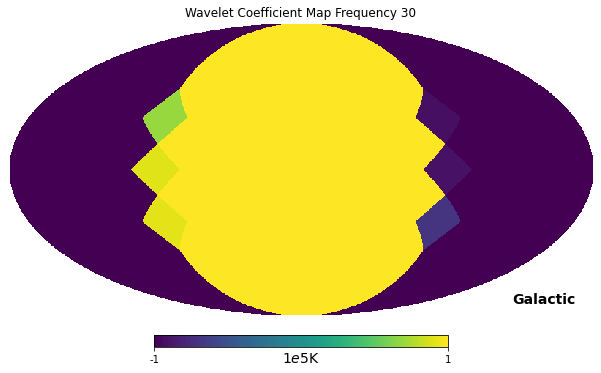

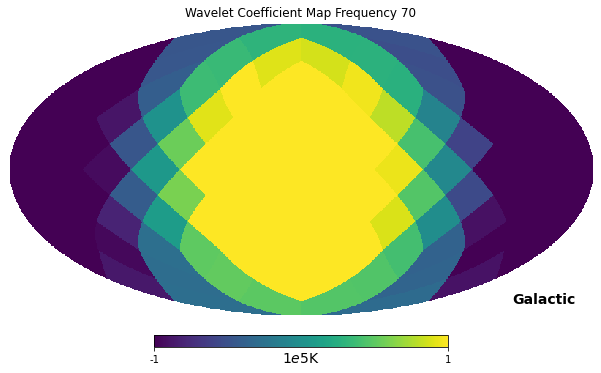

In [ ]:
# original_wavelet_c_j
original_30 = s2fft.inverse(s2fft.forward(original_wavelet_c_j[(frequencies[0], 0)],4),4)
original_70 = s2fft.inverse(s2fft.forward(original_wavelet_c_j[(frequencies[1], 0)],4),4)
print(original_30.shape)
visualize_wavelet_coefficient_map(original_30,"30",-1,1)
visualize_wavelet_coefficient_map(original_70, "70",-1,1)


In [ ]:
original_wavelet_c_j[(frequencies[0], 0)].min()

(-0.00015343674655576405+6.6514353217783115e-21j)

In [ ]:

print(original_30.min(),original_30.max())

(-0.00015343674655576408+2.086064282882645e-20j) (0.00016489770874547721+2.6248204432346723e-21j)


Original map alm shape: (4, 7)


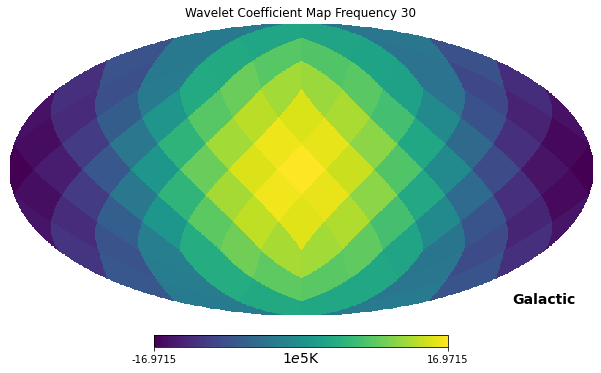

In [ ]:
visualize_wavelet_coefficient_map(original_30,"30")

Original map alm shape: (8, 15)


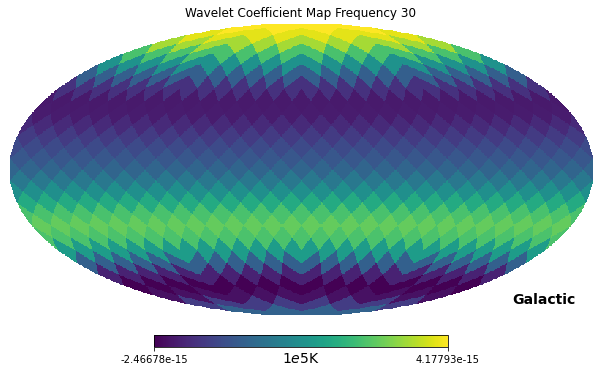

In [ ]:
visualize_wavelet_coefficient_map(double_30,"30")

(4, 7)
Original map alm shape: (4, 7)


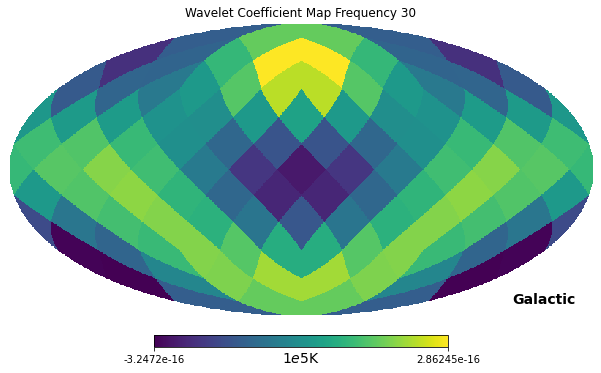

In [ ]:
double_30 = doubled_MW_wav_c_j[(frequencies[0], 0)]
double_70 = doubled_MW_wav_c_j[(frequencies[1], 0)]

doubled_map = np.zeros((double_30.shape[0],double_30.shape[1]), dtype=np.complex128)


for i in range(double_30.shape[0]):
    for j in range(double_30.shape[1]):
        pix_vector = np.array([double_30[i,j],double_70[i,j]])
        # print(double_30[i,j],double_70[i,j])
        # print(pix_vector.shape)
        doubled_map[i,j] = np.dot(weight_vector_load[i,j],pix_vector)
        
trimmed_map = trim_to_original(doubled_map, [4,7])
print(trimmed_map.shape)
visualize_wavelet_coefficient_map(trimmed_map, "30")

# doubled_map_alm = s2fft.forward(trimmed_map, L = trimmed_map.shape[0])
# print(doubled_map_alm.shape)
# doubled_map_hp_alm = mw_alm_2_hp_alm(doubled_map_alm, trimmed_map.shape[0]-1)
# doubled_hp_map = hp.alm2map(doubled_map_hp_alm, nside=trimmed_map.shape[0]-1)